# EV Energy Consumption


In [ ]:
!pip install -q catboost optuna pandas pyarrow

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 25.1 MB/s eta 0:00:00


*To make it easier, I connected Google Drive so you can add the dataset to your Drive and use it directly. This way, you don’t have to repeatedly upload the dataset to Colab, since Colab’s RAM is temporary.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading


In [ ]:
# Bu hücrede proje boyunca sık sık kullanacağım temel sabitleri tanımlıyorum.
CSV_PATH = "/content/drive/MyDrive/final_training_data.csv"
TARGET = "energy_consumption"
USE_GPU = True
SAVE_DIR = "/content/outputs"
SEED = 42

*PyArrow is the implementation of the Apache Arrow library in Python. It stores data in a columnar format, which enables high-performance data processing, and is faster than the default C engine*





In [ ]:
# Reading the dataset
df = pd.read_csv(CSV_PATH, engine="pyarrow")

print("Shape:", df.shape)

df.head().T

Shape: (481411, 25)


,0,1,2,3,4
timestamp,2,3,4,5,6
vehicle_id,veh1,veh1,veh1,veh1,veh1
speed_kmh,0.0,13.824,27.648,41.472,24.68952
lat,39.751093,39.751061,39.750998,39.750903,39.75085
lon,30.502114,30.502096,30.50206,30.502007,30.501967
z,825.839847,825.898326,826.015284,826.190722,826.246155
acceleration,0.0,3.84,3.84,3.84,-4.6618
mass_kg,1916.0,1916.0,1916.0,1916.0,1916.0
soc_pc,91.741386,91.736124,91.721126,91.696298,91.718661
energy_consumption,0.0,4.93,14.04,23.26,-20.94


## Data Preprocessing

Burada kısımda, modelin göreceği veriyi temizleyip, eksikleri tamamlamayarak ve tüm özellikleri aynı ölçekte tutarak XGBoost’un kararlarını daha istikrarlı hale getirelecektir.

In [ ]:
df.head()

,timestamp,vehicle_id,speed_kmh,lat,lon,z,acceleration,mass_kg,soc_pc,energy_consumption,...,device.battery.capacity,frontSurfaceArea,recuperationEfficiency,maximumPower,device.battery.maximumChargeRate,rollDragCoefficient,rotatingMass,radialDragCoefficient,dist_m,slope_pct
0,2,veh1,0.00000,39.751093,30.502114,825.839847,0.0000,1916.0,91.741386,0.00,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,NaN,NaN
1,3,veh1,13.82400,39.751061,30.502096,825.898326,3.8400,1916.0,91.736124,4.93,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,3.842938,1.521728
2,4,veh1,27.64800,39.750998,30.502060,826.015284,3.8400,1916.0,91.721126,14.04,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,7.685875,1.521728
3,5,veh1,41.47200,39.750903,30.502007,826.190722,3.8400,1916.0,91.696298,23.26,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,11.528813,1.521728
4,6,veh1,24.68952,39.750850,30.501967,826.246155,-4.6618,1916.0,91.718661,-20.94,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,6.773789,0.818349


In [ ]:
# Checking null values if exist
null_percentage = (df.isnull().sum() / len(df)) * 100
print(null_percentage)

timestamp                            0.000000
vehicle_id                           0.000000
speed_kmh                            0.000000
lat                                  0.000000
lon                                  0.000000
z                                    0.000000
acceleration                         0.000000
mass_kg                              0.000000
soc_pc                               0.000000
energy_consumption                   0.000000
accel                                0.000000
decel                                0.000000
propulsionEfficiency                 0.000000
airDragCoefficient                   0.000000
constantPowerIntake                  0.000000
device.battery.capacity              0.000000
frontSurfaceArea                     0.000000
recuperationEfficiency               0.000000
maximumPower                         0.000000
device.battery.maximumChargeRate     0.000000
rollDragCoefficient                  0.000000
rotatingMass                      

In [ ]:
df[df["slope_pct"].isnull()].head(10) #to see the reason why could it be the reason

,timestamp,vehicle_id,speed_kmh,lat,lon,z,acceleration,mass_kg,soc_pc,energy_consumption,...,device.battery.capacity,frontSurfaceArea,recuperationEfficiency,maximumPower,device.battery.maximumChargeRate,rollDragCoefficient,rotatingMass,radialDragCoefficient,dist_m,slope_pct
0,2,veh1,0.0,39.751093,30.502114,825.839847,0.000000,1916.0,91.741386,0.00,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,NaN,NaN
216,218,veh1,0.0,39.755141,30.506665,819.135071,-2.101704,1916.0,91.255775,-0.98,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,0.0,NaN
217,219,veh1,0.0,39.755141,30.506665,819.135071,0.000000,1916.0,91.255636,0.13,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,0.0,NaN
218,220,veh1,0.0,39.755141,30.506665,819.135071,0.000000,1916.0,91.255497,0.13,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,0.0,NaN
219,221,veh1,0.0,39.755141,30.506665,819.135071,0.000000,1916.0,91.255358,0.13,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,0.0,NaN
220,222,veh1,0.0,39.755141,30.506665,819.135071,0.000000,1916.0,91.255220,0.13,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,0.0,NaN
221,223,veh1,0.0,39.755141,30.506665,819.135071,0.000000,1916.0,91.255081,0.13,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,0.0,NaN
222,224,veh1,0.0,39.755141,30.506665,819.135071,0.000000,1916.0,91.254942,0.13,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,0.0,NaN
223,225,veh1,0.0,39.755141,30.506665,819.135071,0.000000,1916.0,91.254803,0.13,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,0.0,NaN
224,226,veh1,0.0,39.755141,30.506665,819.135071,0.000000,1916.0,91.254665,0.13,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,0.0,NaN


*Because of the most of the reason (i suppose) is when the vehicle stop or height doesnt change slope becames null so i set them to 0*

In [ ]:
# Filling the null values to 0
df["slope_pct"] = df["slope_pct"].fillna(0)
df["dist_m"] = df["dist_m"].fillna(0)

In [ ]:
# Checking if it worked
null_percentage = (df[['slope_pct', 'dist_m']].isnull().sum() / len(df)) * 100
print(null_percentage)

slope_pct    0.0
dist_m       0.0
dtype: float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481411 entries, 0 to 481410
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   timestamp                         481411 non-null  int64  
 1   vehicle_id                        481411 non-null  object 
 2   speed_kmh                         481411 non-null  float64
 3   lat                               481411 non-null  float64
 4   lon                               481411 non-null  float64
 5   z                                 481411 non-null  float64
 6   acceleration                      481411 non-null  float64
 7   mass_kg                           481411 non-null  float64
 8   soc_pc                            481411 non-null  float64
 9   energy_consumption                481411 non-null  float64
 10  accel                             481411 non-null  float64
 11  decel                             481411 non-null  f

In [ ]:
# ivme ayrımı
# bu sayede enerji tüketimi (hızlanırken) ve rejeneratif enerji kazanımı (yavaşlarken) ayrı ayrı analiz edilebilir.
# verimlilik hesaplarını ve optimizasyonu daha doğru yapmayı sağlar
# Pozitif ivme (gaz) tüketimi artırır; negatif ivme (fren/iniş) rejenerasyon sağlayabilir. Tek sütun olsa bu fark kaybolabilirdi
df["acc_pos"] = df["acceleration"].clip(lower=0)
df["acc_neg"] = (-df["acceleration"]).clip(lower=0)

In [ ]:
# Hız: m/s ve v^2
df["speed_ms"] = df["speed_kmh"] / 3.6

# Aerodinamik: Cd * A
df["CdA"] = df["airDragCoefficient"] * df["frontSurfaceArea"] # bu ikini birleştirip vermek daha mantıklı

*The drops values are selected based on this metrics:*
* The TARGET variable (energy_consumption) is the value we want to predict, so it's separated.
* Columns like timestamp can lead to "temporal memorization," where the model learns specific time points rather than general patterns.
* vehicle_id is used for the group-aware split but shouldn't be a direct feature to avoid "ID leakage." we didnt drop in here but will be dropped after split.
* accel and decel are dropped because they are duplicates of the acceleration feature and acceleration also dropped because we seperate the acceleration previously so we dont need it
* Location features (lat, lon, z) are proxy IDs for specific road segments. The model would memorize geography instead of learning physics.
* Physical constants like frontSurfaceArea airDragCoefficient are used to calculate to aerodinamic so we removed them.
* battery capacity because we found it irreveliant
* speed_kmh removed because we use ms instead.




In [ ]:
from sklearn.model_selection import train_test_split

# Columns to drop from features
drop_cols = {
    TARGET,
    "timestamp",
    "lat", "lon", "z",
    "soc_pc",
    "accel", "decel", "acceleration",
    "speed_kmh",
    "frontSurfaceArea", "device.battery.capacity",
    "airDragCoefficient"
}

# Build X, y
y = df[TARGET].copy()
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [ ]:
# Before training, we sanitize both features (X) and target (y) to remove invalid numerical values.
# np.inf and -np.inf are replaced with NaN.
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)
# Then concatenate X and y into a single DataFrame to drop rows with any missing value
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns=[TARGET])
y = data[TARGET]

print(f"Post-clean shape: {X.shape}")

Post-clean shape: (481411, 16)


## Split strategy — Group-aware by `vehicle_id`


In this step, the dataset is split into train, validation, and test sets grouped by vehicle.
The goal is to ensure that all rows belonging to the same vehicle appear in only one split, preventing ID leakage. Whit this the model will be tested on vehicle it has never seen before and no vehicle appears in more than one split, so the model cannot memorize vehicle-specific patterns.

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

groups = df["vehicle_id"]

X = X.drop(columns=["vehicle_id"])

# First, GroupShuffleSplit is used to allocate 15% of the data to the test set.
#At this stage, all rows for a given vehicle are placed either entirely in the test set or entirely in the train+val set.
def group_split(X, y, groups, test_size=0.15, val_size=0.15, rs=42):

    # Splitting off the test set from the full dataset
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=rs)
    i_tr, i_te = next(gss.split(X, y, groups))

    # Splitting the remaining data into train and validation
    # Adjust val_size to be proportional to the remaining data
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size/(1-test_size), random_state=rs)
    j_tr, j_val = next(gss2.split(X.iloc[i_tr], y.iloc[i_tr], groups.iloc[i_tr]))

    # Extract the actual indices for train, validation, and test
    tr_idx = X.iloc[i_tr].index[j_tr]
    val_idx = X.iloc[i_tr].index[j_val]
    te_idx = X.index[i_te]
    return tr_idx, val_idx, te_idx

# Perform the ground split
train_idx, val_idx, test_idx = group_split(X, y, groups)

# Create train, validation, and test sets
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

print(f"Split -> train:{len(train_idx)}, val:{len(val_idx)}, test:{len(test_idx)}")


Split -> train:342307, val:72919, test:66185


In [ ]:
# Verify no vehicle_id overlap between splits
tr_vid = set(df.loc[X_train.index, "vehicle_id"]) if "vehicle_id" in df.columns else set()
va_vid = set(df.loc[X_val.index, "vehicle_id"]) if "vehicle_id" in df.columns else set()
te_vid = set(df.loc[X_test.index, "vehicle_id"]) if "vehicle_id" in df.columns else set()
print("train∩test:", tr_vid & te_vid)
print("val∩test  :", va_vid & te_vid)
print("train∩val :", tr_vid & va_vid)

train∩test: set()
val∩test  : set()
train∩val : set()


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342307 entries, 0 to 481410
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   mass_kg                           342307 non-null  float64
 1   propulsionEfficiency              342307 non-null  float64
 2   constantPowerIntake               342307 non-null  float64
 3   recuperationEfficiency            342307 non-null  float64
 4   maximumPower                      342307 non-null  float64
 5   device.battery.maximumChargeRate  342307 non-null  float64
 6   rollDragCoefficient               342307 non-null  float64
 7   rotatingMass                      342307 non-null  float64
 8   radialDragCoefficient             342307 non-null  float64
 9   dist_m                            342307 non-null  float64
 10  slope_pct                         342307 non-null  float64
 11  acc_pos                           342307 non-null  float6

# XGBoost


We chose XGBoost because it is a highly efficient and scalable implementation of gradient boosting, which is well-suited for both regression and classification problems.

Energy consumption is affected by the nonlinear interactions of many factors (e.g., aerodynamic drag increases with the square of speed, while the effect of pitch depends on the vehicle's mass). XGBoost, a tree-based ensemble model, can automatically learn these complex relationships.

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the XGBoost
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',           # Early stopping monitors RMSE on eval
    'eta': 0.03,                     # Learning rate
    'max_depth': 5,
    'subsample': 0.5,                # Fraction of samples used for fitting the trees
    'colsample_bytree': 0.8,         # Fraction of features used for fitting the trees/ reduce variance.
    'random_state': SEED,
    'tree_method': 'gpu_hist',
    'device': 'cuda' if USE_GPU else 'cpu'
}

# (learning rate) + large num_boost_round → small steps, rely on early stopping to halt.

# Convert categorical column to 'category' dtype for XGBoost
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')
        X_test[col] = X_test[col].astype('category')

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

evals = [(dtrain, 'train'), (dval, 'eval')]

# Train the model using xgb.train with early stopping
model_xgb = xgb.train(params=xgb_params,
                      dtrain=dtrain,
                      evals=evals,
                      num_boost_round=10000, # Set a large number of boosting rounds
                      early_stopping_rounds=400, # Stop if no improvement on eval set for 400 rounds
                      verbose_eval=250) # Print evaluation results every 250 rounds

print("Training finished")

# Evaluate the model
y_tr_pred = model_xgb.predict(dtrain, iteration_range=(0, model_xgb.best_iteration+1))
y_val_pred_xgb = model_xgb.predict(dval,   iteration_range=(0, model_xgb.best_iteration+1))
y_test_pred_xgb = model_xgb.predict(dtest, iteration_range=(0, model_xgb.best_iteration+1))


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [17:45:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:11.98007	eval-rmse:11.51949
[250]	train-rmse:2.37225	eval-rmse:2.44112
[500]	train-rmse:2.28357	eval-rmse:2.40053
[750]	train-rmse:2.23679	eval-rmse:2.38913
[1000]	train-rmse:2.20340	eval-rmse:2.38639
[1250]	train-rmse:2.17582	eval-rmse:2.38726
[1437]	train-rmse:2.15697	eval-rmse:2.38951
Training finished


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [17:45:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


**MAE (Mean Absolute Error):** The mean of the absolute differences between predictions and actual values. This metric directly evaluates the magnitude of errors, giving each error equal weight. The closer the value is to 0, the closer the predictions are to the true values.

**RMSE (Root Mean Squared Error):** The square root of the mean of squared errors. Squaring increases the impact of large errors, so RMSE is more sensitive to large deviations compared to MAE.

**R² (Coefficient of Determination):** Indicates how much of the variance in the dependent variable is explained by the model.

In [ ]:
# Define metrics function
def metric_dict(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}

In [ ]:
VAL_xgb = metric_dict(y_val, y_val_pred_xgb)
TEST_xgb = metric_dict(y_test, y_test_pred_xgb)

print("XGBoost VALID:", VAL_xgb)
print("XGBoost TEST :", TEST_xgb)

XGBoost VALID: {'MAE': 0.9407826633620383, 'RMSE': 2.384532212466926, 'R2': 0.9592503350749136}
XGBoost TEST : {'MAE': 0.9934570635836802, 'RMSE': 2.376027721795694, 'R2': 0.968261037867403}


The results indicate that the model performs consistently well on both the validation and test sets, suggesting good generalization

On the validation set, the MAE is approximately 0.94 and the RMSE is around 2.38, meaning that on average the prediction error is less than one unit, while larger deviations increase the error magnitude to about 2.38. The R² value of 0.959 shows that the model explains roughly 95.9% of the variance in the target variable. Similarly, on the test set, the MAE is about 0.99 and the RMSE is around 2.37, with an R² of 0.968, which is even slightly higher than the validation score

The close alignment of metrics between validation and test sets demonstrates that the model is not overfitting and can reliably maintain its predictive performance on unseen data.

# Interpreting XGBoost Feature Importance (gain / weight / cover)

**Gain:** Average loss reduction brought by splits on a feature. Higher gain ⇒ that feature’s splits improved RMSE more. This is the most informative of the three because it ties importance to error reduction, not just usage frequency.

**Weight** (split count): How often a feature was used to split. High weight can reflect redundant or shallow splits and may overrate correlated or proxy features; it does not guarantee large error impact.

**Cover:** Average number of training samples affected by splits on a feature (i.e., data “coverage”). High cover indicates broad influence but not necessarily strong predictive power.

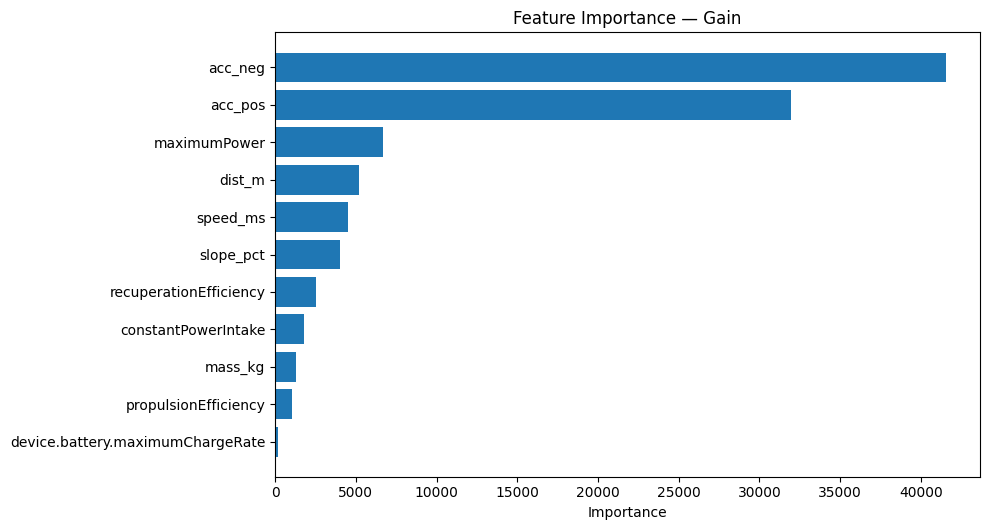

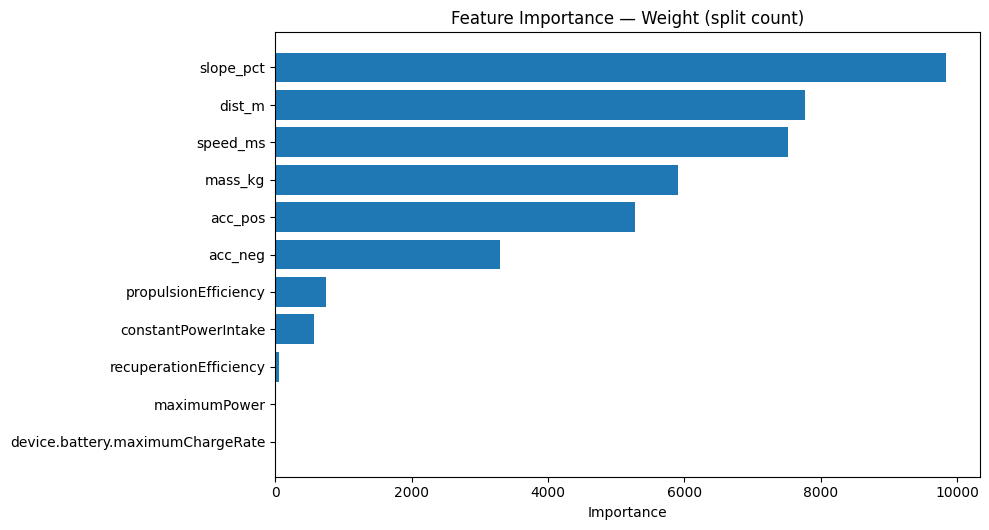

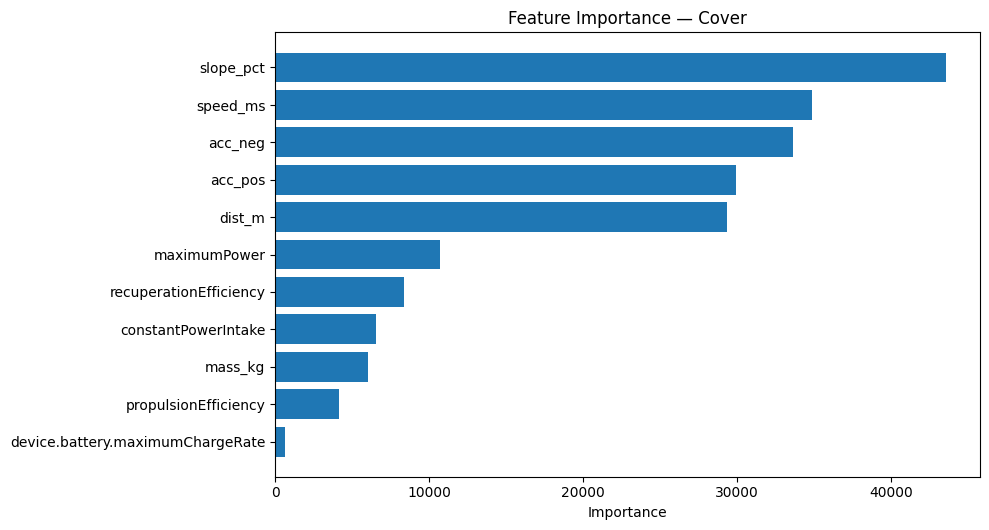

In [ ]:
imp_gain  = model_xgb.get_score(importance_type='gain')
imp_weight= model_xgb.get_score(importance_type='weight')  # split sayısı
imp_cover = model_xgb.get_score(importance_type='cover')

def _plot_imp(imp_dict, title, top_k=30):
    if not imp_dict:
        print(f"{title}: Empty).")
        return
    s = pd.Series(imp_dict, dtype=float).sort_values(ascending=False).head(top_k)
    plt.figure(figsize=(10, 0.4*len(s)+1))
    plt.barh(range(len(s)), s.values)
    plt.yticks(range(len(s)), s.index)
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

_plot_imp(imp_gain,   "Feature Importance — Gain")
_plot_imp(imp_weight, "Feature Importance — Weight (split count)")
_plot_imp(imp_cover,  "Feature Importance — Cover")

Looking at **gain** (error reduction impact), the most influential features are acc_neg and acc_pos, far ahead of the others. This means that deceleration and acceleration patterns contribute the most to lowering RMSE, suggesting that vehicle dynamics have the strongest direct effect on energy consumption. Other notable contributors include maximumPower and dist_m, which align with expected physical determinants of energy use.

In the **weight** plot (split frequency), the top features shift toward slope_pct, dist_m, and speed_ms. These are used very often to split the data, but frequent usage does not always mean high predictive power — they might be easy split points that offer moderate gains. For example, slope_pct has high weight but a relatively lower gain, indicating it’s used widely but each split yields smaller incremental improvements.

The **cover** plot (average number of samples affected by splits) again highlights slope_pct and speed_ms as features that influence a large portion of the dataset. This suggests they act as broad “first-layer” split criteria that partition major data regions, while acceleration features, despite their higher gain, tend to refine predictions within smaller subsets.

# Permutation Importance

I shuffle the values of a feature only in the validation set (all other features remain the same). If the shuffling increases the RMSE, that feature is critical for the model; the magnitude of the increase is the importance.

I repeat this n times (default 5) for each feature and calculate the mean and standard deviation of ΔRMSE. I plot the mean and show the variability in the error bars.

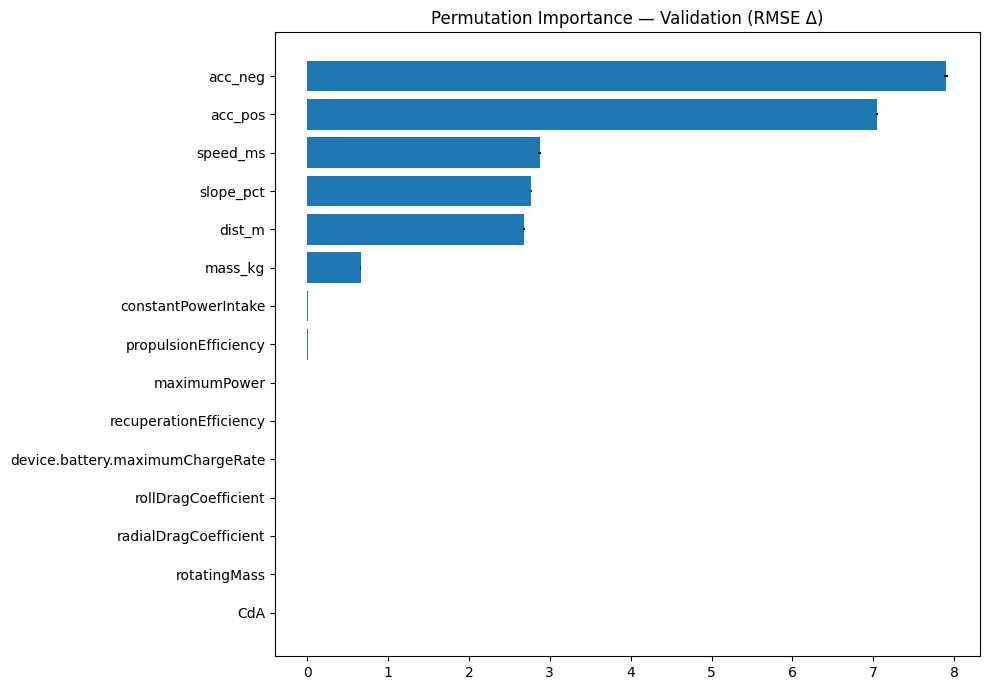

,rmse_delta_mean,rmse_delta_std
acc_neg,7.896055,0.026810
acc_pos,7.046951,0.012793
speed_ms,2.873454,0.015196
slope_pct,2.771685,0.005873
dist_m,2.685103,0.011174
mass_kg,0.664473,0.007067
constantPowerIntake,0.010900,0.000760
propulsionEfficiency,0.009148,0.001649
maximumPower,0.000263,0.000069
recuperationEfficiency,0.000074,0.000205


Base RMSE (val): 2.3845


In [ ]:
assert all(v in globals() for v in ['X_val','y_val']), "X_val / y_val could not be found."

def predict_val(arr_or_df):
    if isinstance(arr_or_df, pd.DataFrame):
        dm = xgb.DMatrix(arr_or_df, enable_categorical=True)
    else:
        dm = xgb.DMatrix(arr_or_df, enable_categorical=True)
    return model_xgb.predict(dm, iteration_range=(0, getattr(model_xgb,'best_iteration', 0)+1))

# Base RMSE
y_pred_base = predict_val(X_val)
base_rmse = np.sqrt(mean_squared_error(y_val, y_pred_base))

def permutation_importance_rmse(X, y, n_repeats=5, top_k=30, random_state=42):
    rng = np.random.RandomState(random_state)
    cols = list(X.columns)
    importances = {}
    for c in cols:
        deltas = []
        for _ in range(n_repeats):
            Xp = X.copy()
            Xp[c] = Xp[c].sample(frac=1.0, random_state=rng).values  # permutation
            yp = predict_val(Xp)
            rmse = np.sqrt(mean_squared_error(y, yp))
            deltas.append(rmse - base_rmse)
        importances[c] = (np.mean(deltas), np.std(deltas))
    s = pd.Series({k:v[0] for k,v in importances.items()}).sort_values(ascending=False).head(top_k)
    e = pd.Series({k:v[1] for k,v in importances.items()}).loc[s.index]
    return s, e

perm_mean, perm_std = permutation_importance_rmse(X_val, y_val, n_repeats=5, top_k=30)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 0.4*len(perm_mean)+1))
ypos = np.arange(len(perm_mean))
plt.barh(ypos, perm_mean.values, xerr=perm_std.values)
plt.yticks(ypos, perm_mean.index)
plt.gca().invert_yaxis()
plt.title('Permutation Importance — Validation (RMSE Δ)')
plt.tight_layout()
plt.show()

display(pd.DataFrame({"rmse_delta_mean":perm_mean, "rmse_delta_std":perm_std}).head(10))
print(f"Base RMSE (val): {base_rmse:.4f}")


Without relying on within-tree rules (gain/weight/cover), it truly answers the question, "How much will the model's error increase if I perturb this feature?"

The larger the ΔRMSE, the more critical the contribution of that feature; the higher the standard deviation, the less stable the effect (may be conditional).

# Hyperparameter Optimization with Optuna (XGBoost)

Optuna is used for automatically search for the best set of XGBoost hyperparameters that
minimize validation RMSE.

In each trial, the validation set RMSE value was returned, and Optuna attempted to minimize this value. After a total of 50 trials (n_trials=50), the parameter set that yielded the lowest RMSE value was determined to be the "best."


In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np # Import numpy for sqrt

# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float('eta', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'seed': SEED,
        'tree_method': 'hist',
        'device': 'cuda' if USE_GPU else 'cpu'
    }

    # Convert categorical column to 'category' dtype for XGBoost
    X_train_tuned = X_train.copy()
    X_val_tuned = X_val.copy()
    for col in X_train_tuned.columns:
        if X_train_tuned[col].dtype == 'object':
            X_train_tuned[col] = X_train_tuned[col].astype('category')
            X_val_tuned[col] = X_val_tuned[col].astype('category')


    # Create DMatrix using X_train, y_train, X_val, and y_val
    dtrain_tuned = xgb.DMatrix(X_train_tuned, label=y_train, enable_categorical=True)
    dval_tuned = xgb.DMatrix(X_val_tuned, label=y_val, enable_categorical=True)

    evals = [(dtrain_tuned, 'train'), (dval_tuned, 'eval')]

    # Train the model with early stopping
    model = xgb.train(params=param,
                      dtrain=dtrain_tuned,
                      evals=evals,
                      num_boost_round=10000, # Large number, early stopping will stop it
                      early_stopping_rounds=400,
                      verbose_eval=False) # False to avoid excessive output during tuning

    # Predict on the validation set
    y_val_pred = model.predict(dval_tuned)

    # Calculate RMSE on the validation set
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # Store the best iteration for later use
    trial.set_user_attr("best_iteration", model.best_iteration)

    return rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize') # Minimize RMSE

# Run the optimization
study.optimize(objective, n_trials=50)

[I 2025-08-14 17:58:59,577] A new study created in memory with name: no-name-f6a08573-adb5-4fb1-8ef8-98b85a0a69ba
[I 2025-08-14 17:59:01,735] Trial 0 finished with value: 2.744600746170715 and parameters: {'eta': 0.376530878482307, 'max_depth': 9, 'subsample': 0.7759749874876787, 'colsample_bytree': 0.8907184051117092, 'lambda': 0.054863624901123405, 'alpha': 1.6934615048988153, 'min_child_weight': 1.15399817400167}. Best is trial 0 with value: 2.744600746170715.
[I 2025-08-14 17:59:03,569] Trial 1 finished with value: 2.393195905531174 and parameters: {'eta': 0.14401743371757403, 'max_depth': 5, 'subsample': 0.9575825182084907, 'colsample_bytree': 0.7105474909587535, 'lambda': 8.587110120235824, 'alpha': 0.04910825996452994, 'min_child_weight': 0.08380642527011536}. Best is trial 1 with value: 2.393195905531174.
[I 2025-08-14 17:59:05,304] Trial 2 finished with value: 2.4408144882956164 and parameters: {'eta': 0.3212254814021588, 'max_depth': 4, 'subsample': 0.8823935211612386, 'colsa

In [ ]:
print("Best parameters:", study.best_params)

Best parameters: {'eta': 0.01739709280325996, 'max_depth': 7, 'subsample': 0.9182953777281864, 'colsample_bytree': 0.8483169783344654, 'lambda': 3.853399272015826, 'alpha': 5.199571558563614, 'min_child_weight': 0.12388515565729452}


In [ ]:
# Training the final model with the best parameters on the full training set (X_train, y_train)
best_params = study.best_params
final_xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': SEED,
    'tree_method': 'hist',
    'device': 'cuda' if USE_GPU else 'cpu',
    **best_params # Include the best parameters found by Optuna
}

# Convert categorical column to 'category' dtype for XGBoost for final training
X_train_final = X_train.copy()
X_test_final = X_test.copy()
X_val_final = X_val.copy()
for col in X_train_final.columns:
    if X_train_final[col].dtype == 'object':
        X_train_final[col] = X_train_final[col].astype('category')
        X_test_final[col] = X_test_final[col].astype('category')
        X_val_final[col] = X_val_final[col].astype('category')

dtrain_final = xgb.DMatrix(X_train_final, label=y_train, enable_categorical=True)
dtest_final = xgb.DMatrix(X_test_final, label=y_test, enable_categorical=True)
dval_final = xgb.DMatrix(X_val_final, label=y_val, enable_categorical=True)

# Train the final model
final_model_xgb = xgb.train(params=final_xgb_params,
                           dtrain=dtrain_final,
                           num_boost_round=study.best_trial.user_attrs["best_iteration"], # Use the best number of iterations from tuning
                           verbose_eval=False)


In [ ]:
# Evaluate the final model on the test set
y_test_pred_final_xgb = final_model_xgb.predict(dtest_final)
y_valid_pred_final_xgb = final_model_xgb.predict(dval_final)

TEST_final_xgb = metric_dict(y_test, y_test_pred_final_xgb)
VAL_final_xgb = metric_dict(y_val, y_valid_pred_final_xgb)

print("\nFinal XGBoost TEST performance with tuned hyperparameters:")
print(TEST_final_xgb)
print("\nFinal XGBoost VALID performance with tuned hyperparameters:")
print(VAL_final_xgb)



Final XGBoost TEST performance with tuned hyperparameters:
{'MAE': 0.955499211690555, 'RMSE': 2.3537604924905424, 'R2': 0.9688531413161233}

Final XGBoost VALID performance with tuned hyperparameters:
{'MAE': 0.9067562707506408, 'RMSE': 2.3634644435815, 'R2': 0.9599672153064104}


**TEST set:**

MAE: 0.99 → 0.95 (~4% improvement)

RMSE: 2.38 → 2.35 (slight improvement)

R²: 0.968 → 0.9689 (very small increase)

=============================================

**VALID set:**

MAE: 0.94 → 0.90 (~4% improvement)

RMSE: 2.38 → 2.36 (slight improvement)

R²: 0.959 → 0.9601 (minor increase)

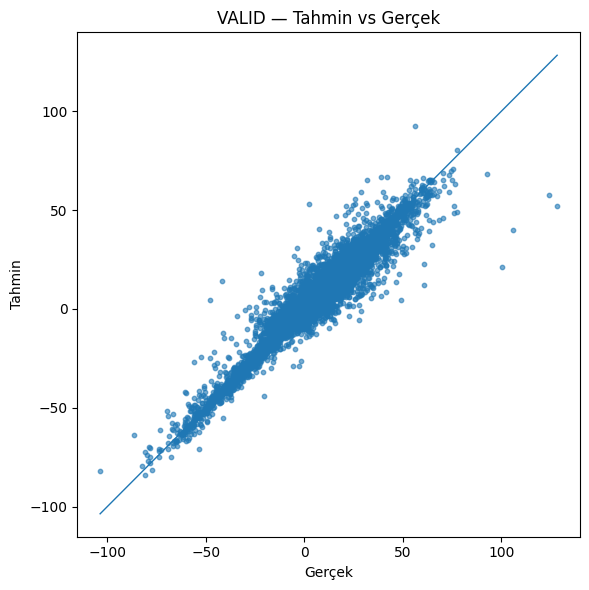

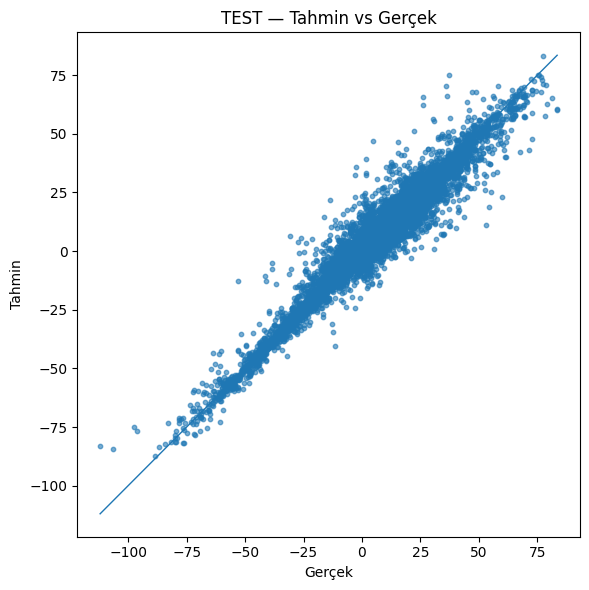

In [ ]:
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=10, alpha=0.6)
    mn, mx = np.min([y_true.min(), y_pred.min()]), np.max([y_true.max(), y_pred.max()])
    plt.plot([mn, mx], [mn, mx], lw=1)     # 45° referans
    plt.xlabel("Gerçek")
    plt.ylabel("Tahmin")
    plt.title(title)
    ax = plt.gca()
    # Removed the call to the undefined function _annot_metrics
    # _annot_metrics(ax, y_true, y_pred)
    plt.tight_layout()
    plt.show()

# Ensure y_val, y_valid_pred_final_xgb, y_test, and y_test_pred_final_xgb are defined
# These variables should be available after training the final XGBoost model (cell 6798bceb)
try:
    plot_pred_vs_actual(y_val,  y_valid_pred_final_xgb, "VALID — Tahmin vs Gerçek")
    plot_pred_vs_actual(y_test, y_test_pred_final_xgb,  "TEST — Tahmin vs Gerçek")
except NameError as e:
    print(f"Error: {e}. Please ensure that y_val, y_valid_pred_final_xgb, y_test, and y_test_pred_final_xgb are defined by running the final model training cell.")

In [ ]:
import xgboost as xgb

target_vehicle_id = "veh103"

# Get the test set data for the target vehicle
X_test_vehicle = df.loc[
    (df["vehicle_id"] == target_vehicle_id) & (split == "test"),
    X_train.columns
].dropna()

# Get the actual target values for the vehicle
y_true_vehicle = df.loc[
    (df["vehicle_id"] == target_vehicle_id) & (split == "test"),
    TARGET
].values

# Convert object-type columns to category type (to match training format)
for col in X_test_vehicle.columns:
    if X_test_vehicle[col].dtype == 'object':
        X_test_vehicle[col] = X_test_vehicle[col].astype('category')

# Create a DMatrix for XGBoost prediction
dtest_vehicle = xgb.DMatrix(X_test_vehicle, label=y_true_vehicle, enable_categorical=True)

# Make predictions
y_pred_vehicle = final_model_xgb.predict(dtest_vehicle)

# Calculate total consumption
total_true = y_true_vehicle.sum()
total_pred = y_pred_vehicle.sum()
diff = total_pred - total_true
diff_pct = 100 * diff / total_true

print(f"\n Vehicle: {target_vehicle_id}")
print(f"🔹 Actual Total Consumption   : {total_true:.2f} Wh")
print(f"🔹 Predicted Total Consumption: {total_pred:.2f} Wh")
print(f"🔹 Difference                  : {diff:.2f} Wh ({diff_pct:.2f}%)")



 Vehicle: veh103
🔹 Actual Total Consumption   : 2591.63 Wh
🔹 Predicted Total Consumption: 2551.82 Wh
🔹 Difference                  : -39.81 Wh (-1.54%)


## CatBoost


In [ ]:
# Categorical columns
cat_cols = []
for c in X.columns:
    if X[c].dtype == object or pd.api.types.is_string_dtype(X[c]) or pd.api.types.is_categorical_dtype(X[c]):
        cat_cols.append(c)
# Optionally include small-cardinality integers
for c in X.columns:
    if c not in cat_cols and (np.issubdtype(X[c].dtype, np.integer)) and X[c].nunique(dropna=True) <= 50:
        cat_cols.append(c)

/tmp/ipython-input-268463984.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if X[c].dtype == object or pd.api.types.is_string_dtype(X[c]) or pd.api.types.is_categorical_dtype(X[c]):


In [ ]:
import os, json
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

os.makedirs(SAVE_DIR, exist_ok=True)

cat_idx = [X_train.columns.get_loc(c) for c in cat_cols if c in X_train.columns]

train_pool = Pool(X_train, y_train, cat_features=cat_idx)
valid_pool = Pool(X_val, y_val, cat_features=cat_idx)
test_pool  = Pool(X_test, y_test, cat_features=cat_idx)

params = dict(
    loss_function="RMSE",
    iterations=4000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=6.0,
    random_state=SEED,
    od_type="Iter", od_wait=400,
    task_type=("GPU" if USE_GPU else "CPU"),
    bootstrap_type="Bayesian",
    grow_policy="Lossguide",
    verbose=250
)

model_cat = CatBoostRegressor(**params)
model_cat.fit(train_pool, eval_set=valid_pool, verbose=250)

VAL_cat = metric_dict(y_val, model_cat.predict(valid_pool))
TEST_cat = metric_dict(y_test, model_cat.predict(test_pool))
print("CatBoost VALID:", VAL_cat)
print("CatBoost TEST :", TEST_cat)

os.makedirs(SAVE_DIR, exist_ok=True)
with open(f"{SAVE_DIR}/catboost_metrics.json","w") as f:
    json.dump({"valid":VAL_cat,"test":TEST_cat,"target":TARGET,"params":params}, f, indent=2)
print("Saved:", f"{SAVE_DIR}/catboost_metrics.json")


0:	learn: 11.9641687	test: 11.5030049	best: 11.5030049 (0)	total: 15.8ms	remaining: 1m 3s
250:	learn: 2.3711418	test: 2.4411237	best: 2.4411237 (250)	total: 1.57s	remaining: 23.4s
500:	learn: 2.2930321	test: 2.4050230	best: 2.4050230 (500)	total: 3.05s	remaining: 21.3s
750:	learn: 2.2473420	test: 2.3947823	best: 2.3947500 (749)	total: 4.43s	remaining: 19.2s
1000:	learn: 2.2138165	test: 2.3885781	best: 2.3884213 (995)	total: 5.75s	remaining: 17.2s
1250:	learn: 2.1859308	test: 2.3842842	best: 2.3842458 (1248)	total: 7.07s	remaining: 15.5s
1500:	learn: 2.1618872	test: 2.3815293	best: 2.3815293 (1500)	total: 8.35s	remaining: 13.9s
1750:	learn: 2.1400432	test: 2.3796218	best: 2.3794114 (1733)	total: 9.64s	remaining: 12.4s
2000:	learn: 2.1202093	test: 2.3780913	best: 2.3779983 (1984)	total: 10.9s	remaining: 10.9s
2250:	learn: 2.1020209	test: 2.3769151	best: 2.3766718 (2230)	total: 12.2s	remaining: 9.51s
2500:	learn: 2.0853985	test: 2.3759393	best: 2.3758458 (2498)	total: 13.5s	remaining: 8.1

Validasyon setinde MAE ≈ 0.94 ve R² ≈ 0.96 olması, modelin veri içindeki varyansın %96’sını yakaladığını ve hataların ortalama mutlak büyüklüğünün oldukça düşük olduğunu gösteriyor. RMSE’nin 2.37 olması da büyük hataların bile kontrol altında olduğunu işaret ediyor.

Test setinde MAE ≈ 1.00, R² ≈ 0.968 ve RMSE ≈ 2.39 ile validasyon setine çok yakın performans var. Bu, overfitting riskinin düşük olduğunu, modelin genelleme kabiliyetinin güçlü olduğunu ve veri dağılımları arasında ciddi fark bulunmadığını gösteriyor.

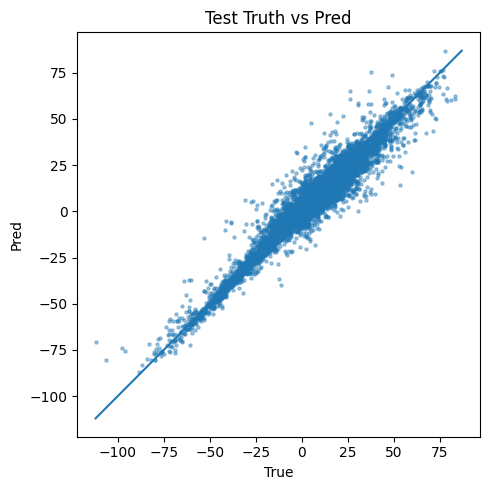

In [ ]:
import matplotlib.pyplot as plt
yhat = model_cat.predict(X_test)
plt.figure(figsize=(5,5))
plt.scatter(y_test, yhat, s=5, alpha=0.4)
lo, hi = min(y_test.min(), yhat.min()), max(y_test.max(), yhat.max())
plt.plot([lo,hi],[lo,hi]); plt.xlabel("True"); plt.ylabel("Pred"); plt.title("Test Truth vs Pred"); plt.tight_layout(); plt.show()
